# Apple Stock Price Prediction 
## Step 3 Pre-processing and Training data 


This step consists of identifying predictor, feature variables and prepare the data redy for modelling stage, that includes testing for stationarity for time series modelling and converting into stationarity (if required) and then spliting the data into training and test set.

### Load Relevant Libraries

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# to ignore warning message

import warnings
warnings.filterwarnings('ignore')

### Load the Data
Load Apple's stock data saved after EDA in step 2

In [2]:
apple = pd.read_csv('data/apple_stockdata_EDA.csv')
apple.head(5)

,date,close
0,1998-01-02,16.25
1,1998-01-05,15.88
2,1998-01-06,18.94
3,1998-01-07,17.50
4,1998-01-08,18.19


### Set Index with Date Column

In [3]:
# Set the index of the dataset with date column

apple.set_index('date', inplace=True)


# Convert index to datetime data type

apple.index = pd.to_datetime(apple.index)
apple.head(5)

,close
date,
1998-01-02,16.25
1998-01-05,15.88
1998-01-06,18.94
1998-01-07,17.50
1998-01-08,18.19


## Patterns in the Data
As an investor we always hope the prices would increse day by day. But price fluctuates over days and eventualy see some gain over months, quarters or years. Like any time-series data, stock price can be decomposed into trend, seasonality and residual parts. 
- **Trend:** price tendency over a time period. e.g. if the price is increasing/decreasing over a year
- **Seasonality:** periodic variation in the price that we see every year. It tells which part of the year price increases/decreases and that happens in cyclic manner over the years
- **Residual:** non systematic component of the price which is not structured and termed as noise

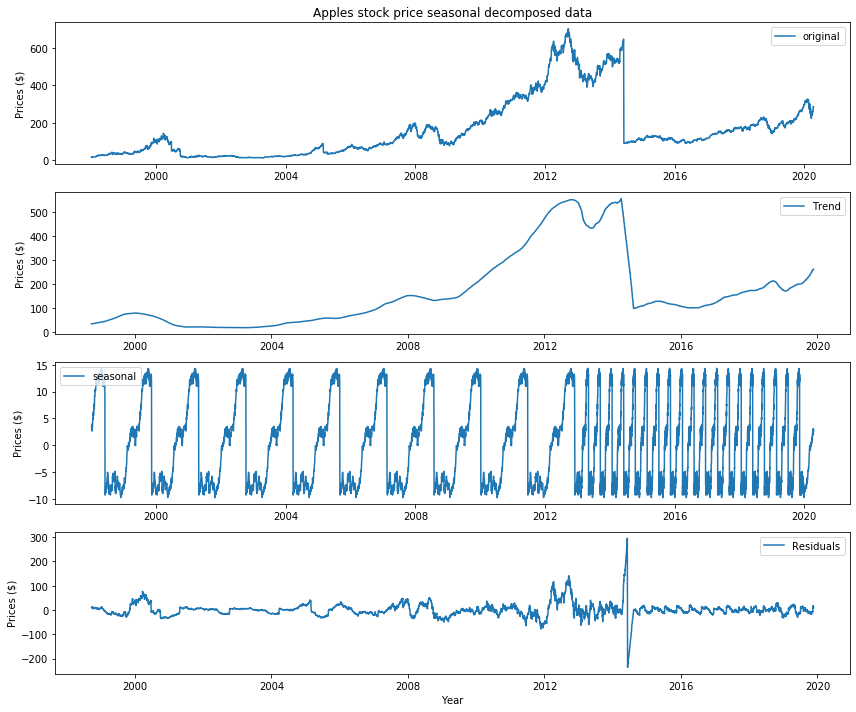

In [24]:
# Import seasonal_decompose 

from statsmodels.tsa.seasonal import seasonal_decompose

# apply decompomposition on Apple

decomposition = seasonal_decompose(apple, model= 'additive', freq=365)    # additive worked better in terms of seasonality decomposition
                                                            # compared to multiplicative

# assign trend, seasonal and residual components from decomposed data 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


# Plot the original data, the trend, the seasonality, and the residual

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(apple, label = 'original')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.title('Apples stock price seasonal decomposed data')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.xlabel('Year')
plt.tight_layout()

- The trend for Apples stock price is increasing for most of the time, there are few decreasing trends which come from stock splits and market adjustment 
- Seasonality is constant over time but follows strictly cyclic manner. That is every year there are specific times when stock rises and falls and the pattern follows every year

### Seasonality over a Year 
- Lets zoom into the decomposed data for over two years (for better visibility) to see how the price evolves over the year trend wise and season wise

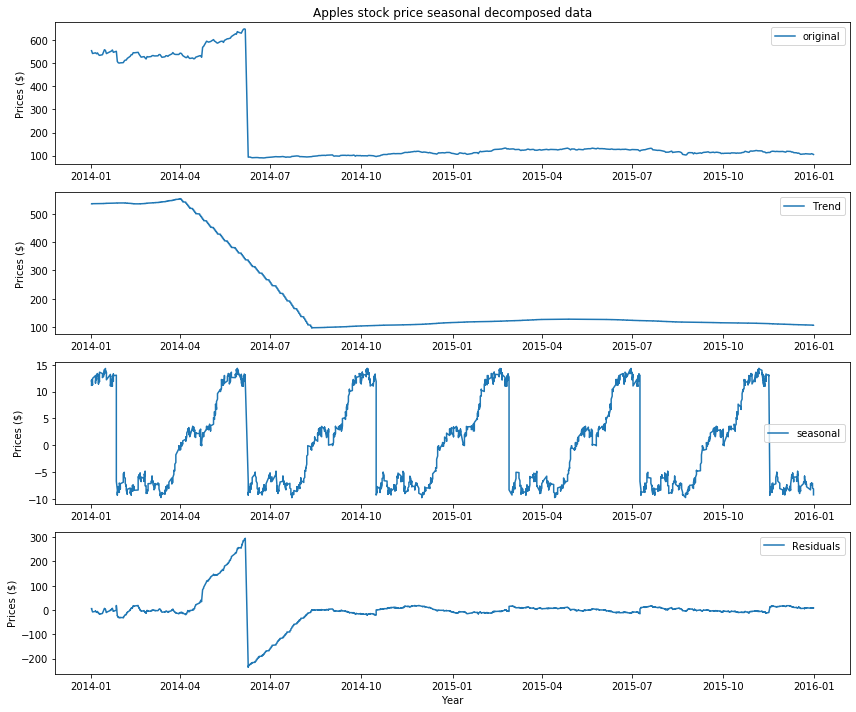

In [28]:
# stock price data for 2014-2016

y_2014_2016 = apple[(trend.index >= '2014-01-01') & (trend.index <= '2016-01-01')]


# trend, seasonality and residual for 2014-2016

trend_2014_2016=  trend[(trend.index >= '2014-01-01') & (trend.index <= '2016-01-01')]
seasonal_2014_2016 =  seasonal[(trend.index >= '2014-01-01') & (trend.index <= '2016-01-01')]
residual_2014_2016 =  residual[(trend.index >= '2014-01-01') & (trend.index <= '2016-01-01')]


# Plot the original data, the trend, the seasonality, and the residual for 2014-2016 Apples stock data

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(y_2014_2016, label = 'original')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.title('Apples stock price seasonal decomposed data')
plt.subplot(412)
plt.plot(trend_2014_2016, label = 'Trend')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.subplot(413)
plt.plot(seasonal_2014_2016, label = 'seasonal')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.subplot(414)
plt.plot(residual_2014_2016, label = 'Residuals')
plt.legend(loc = 'best')
plt.ylabel('Prices ($)')
plt.xlabel('Year')
plt.tight_layout()

- The trend kept decresing over two years
- Looking intot the seasonal variation, price keeps changing in a cyclic seasonal manner


## Stationarity Check
-  The Apple's trend data kept on increasing for most of the time with few dips in the line. So the data is expected to have mean value that varies over time
- The seasonality variation looks constant over time. The price data expected to have constant variance over time
- If the time series data is non-stationary it would not be fit for modelling. Before modelling stage we need to check stationarity of the data, if not transform it untill, stationarity condition is met
- The following section will check on the statioraty on the Apples stock price data

#### Visual Check
- The trend component seems to vary over time, the mean is not constant over time
- Visual check comes handy as a first guess, but quantification is needed to be certain 

#### Statistical Test

- Of the many, two mostly used stationarity checks will be done based on statistical hypothetical testing


- **ADF (Augmented Dickey-Fuller) test**:

This method looks for unit root in the series. The hypothesis for this test are:

**Null Hypothesis**: The series has a unit root (value of a =1) (non-stationary)

**Alternate Hypothesis**: The series has no unit root (stationary)
If the p-value is less than 0.05 then we can reject the the null hypothes i.e. the data is stationary and the data has constant mean and variance over time.

- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test**:

Slightly less popular than ADF, but needed as a double check along with ADF test. The hypothesis for KPSS test is opposite of ADF test:

**Null Hypothesis**: The process in trend stationary (non-stationary)

**Alternate Hypothesis**: The series has a unit root (stationary)
If the p-value is greater than 0.05 then we can reject the the null hypothes i.e. the data is stationary and the data has constant mean and variance over time.



##### ADF Test

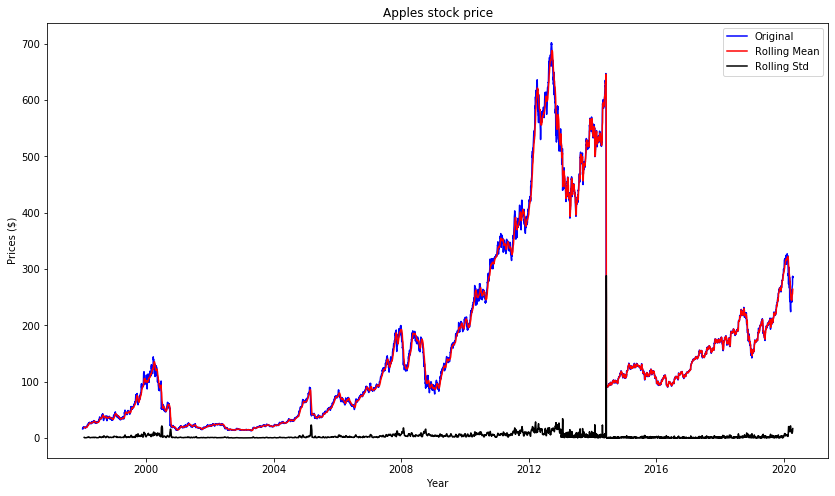

In [29]:
# Lets look at the Stock price data again, visualize how the mean and variance evolve over time

# mean over time
rolmean = apple.rolling(12).mean()

# variance over time
rolstd = apple.rolling(12).std()

# plot original data along with mean and variance, how it vary over time
plt.figure(figsize=(14,8))
plt.plot(apple, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.ylabel('Prices ($)')
plt.xlabel('Year')
plt.legend(loc='best')
plt.title('Apples stock price')
plt.show()

- Clearly the mean and variance are time varying

In [30]:
# function for ADF test

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of ADF Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


# apply ADF test on the Apples stock price data

adf_test(apple)

Results of ADF Test:
Test Statistic                    -2.167693
p-value                            0.218179
#Lags Used                         0.000000
Number of Observations Used    10893.000000
Critical Value (1%)               -3.430950
Critical Value (5%)               -2.861805
Critical Value (10%)              -2.566911
dtype: float64


**Results of ADF test**: 
- p-value is greater than 0.05
- test static is greater than critical values
- fail to reject the null hypothesis 
- ADF test suggests the data is non-stationary

##### KPSS Test

In [31]:
# function for kpss test

from statsmodels.tsa.stattools import kpss


#define KPSS

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    print('Test statistic:'+ str(kpsstest[0]))
    print('p-value is:'+ str(kpsstest[1]))
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        print('Critical value %' + str(key) + ' = ' +str(value) )

kpss_test(apple)

Results of KPSS Test:
Test statistic:2.968822826212239
p-value is:0.01
Critical value %10% = 0.347
Critical value %5% = 0.463
Critical value %2.5% = 0.574
Critical value %1% = 0.739


**Results of KPSS test**: 
- p-value is less than 0.05
- test static is greater than critical values
- reject the null hypothesis 
- KPSS test suggests the data is non-stationary

Both ADF and KPSS tests suggest that the time series data is non-stationary

### Transform Data for Stationarity
- Remind ourselves that for time series forecasting it is necessary to transform a non-stationary data into stationary
- Mainly two types of transformation can be applied:
- **1. Differencing:** defined as, y(t) = y(t) - y(t-n). when n=1 then we are are taking diferences between two days (given daily data). like wise, if n=30, then taking changes for a month. diefferencing mehtod is very useful when the mean of the data is time varying
- **2. Transformation:** generally applying logarithm. root or power transform to make the time varying variance stationary. Log is used to dampen out highly varying data. whereas power is used when the variance decays down over time.

- for our case, we wil start with differencing method as from the seasonality we observed varying mean over time

#### Differencing Method

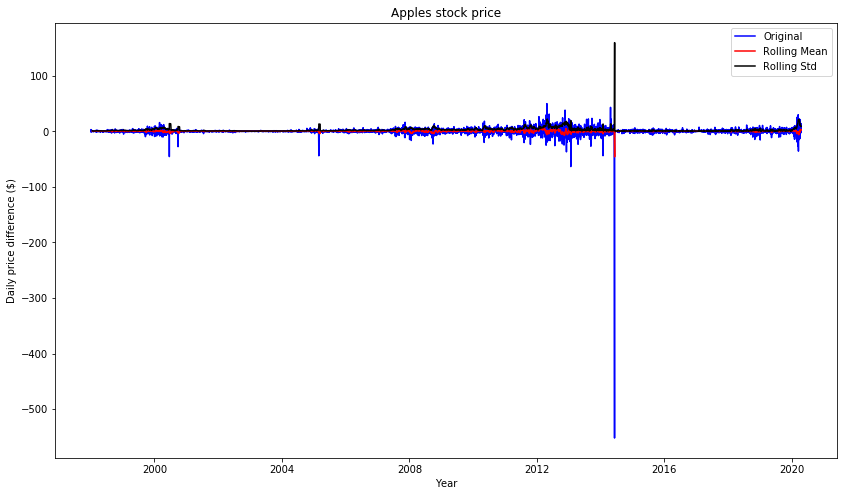

In [32]:
## take the day difference

apple_diff = apple-apple.shift(1)
apple_diff.dropna(inplace=True)


# calculating the rolling mean

rolmean_diff = apple_diff.rolling(12).mean()
rolstd_diff = apple_diff.rolling(12).std()

# plotting the differenced data along with rolling mean and variance

plt.figure(figsize=(14,8))
plt.plot(apple_diff, color='blue',label='Original')
plt.plot(rolmean_diff, color='red', label='Rolling Mean')
plt.plot(rolstd_diff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.ylabel('Daily price difference ($)')
plt.xlabel('Year')
plt.title('Apples stock price')
plt.show()

- time variation on the rolling mean greatly reduced

**Apply stationarity test on Differenced data**

In [33]:
# ADF test
adf_test(apple_diff)


Results of ADF Test:
Test Statistic                  -105.364868
p-value                            0.000000
#Lags Used                         0.000000
Number of Observations Used    10892.000000
Critical Value (1%)               -3.430951
Critical Value (5%)               -2.861805
Critical Value (10%)              -2.566911
dtype: float64


- p-value is less than 0.05. reject the null hypothesis
- suggests the Apple daily price differenced data is stationary

In [34]:
# KPSS test
kpss_test(apple_diff)

Results of KPSS Test:
Test statistic:0.06910143298733797
p-value is:0.1
Critical value %10% = 0.347
Critical value %5% = 0.463
Critical value %2.5% = 0.574
Critical value %1% = 0.739


- p-value is greater than 0.05. fails to reject the null hypothesis
- suggests the Apple daily price differenced data is stationary

Both the ADF and KPSS tests on daily price differneced data confirms the time series data is now stationary.

#### Just see how the Log Transformation Performs

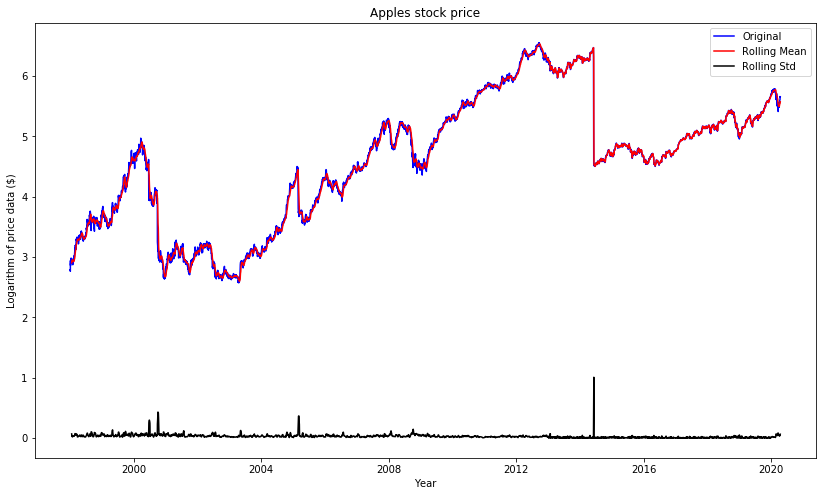

In [35]:
# take logarithm of the data

apple_log= np.log(apple)


# take the rolling mean and variance

rolmean_log = apple_log.rolling(12).mean()
rolstd_log = apple_log.rolling(12).std()

# plot the log transformed data

plt.figure(figsize=(14,8))
plt.plot(apple_log, color='blue',label='Original')
plt.plot(rolmean_log, color='red', label='Rolling Mean')
plt.plot(rolstd_log, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.ylabel('Logarithm of price data ($)')
plt.xlabel('Year')
plt.title('Apples stock price')
plt.show()

- the rolling mean pattern still remains the same

**Apply stationarity test on Log data**

In [36]:
# ADF test
adf_test(apple_log)


Results of ADF Test:
Test Statistic                    -2.287405
p-value                            0.176062
#Lags Used                         4.000000
Number of Observations Used    10889.000000
Critical Value (1%)               -3.430951
Critical Value (5%)               -2.861805
Critical Value (10%)              -2.566911
dtype: float64


- p-value is greater than 0.05. fails to reject null hypothesis
- suggests non-stationary

In [37]:
# KPSS test
kpss_test(apple_log)

Results of KPSS Test:
Test statistic:6.913460053648387
p-value is:0.01
Critical value %10% = 0.347
Critical value %5% = 0.463
Critical value %2.5% = 0.574
Critical value %1% = 0.739


- p-value is less than 0.05. rejects null hypothesis
- suggests non-stationary

The log transfromation can not transform Apples atock price data into stationary. The differencing method can. Now the data is model ready

### Train Test Split
The next step is modelling. Like any other analysis time series forecasting also requires, test data which will be used to test the integrity of the prediction. We have almost 20 years of stock price data. The training data will be taken from the beginning till end of 2015. The rest of the data will be used at test data.


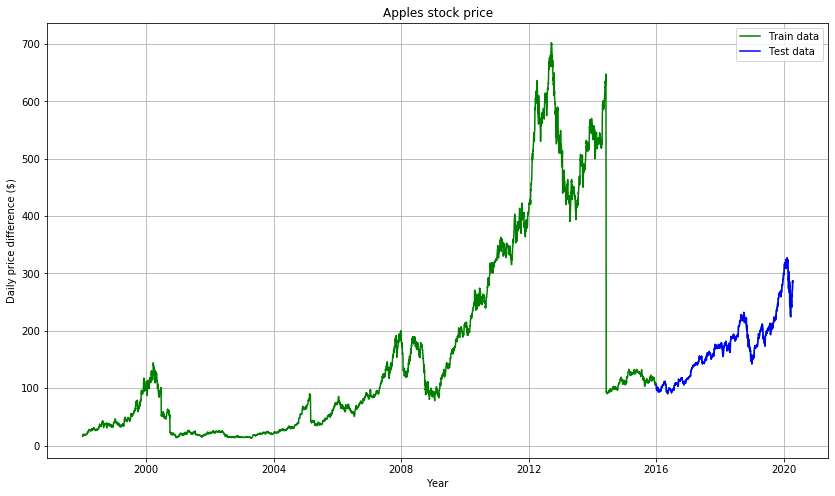

In [38]:
# split data into train and training set

train_data, test_data = apple[apple.index <= '2016-01-01'], apple[apple.index >= '2016-01-01']

# plot the training and testing data

plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Daily price difference ($)')
plt.plot(apple, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('Apples stock price')
plt.legend()
plt.show()

### Save Train-Test Data for the Modelling Step

In [39]:
# train data
train_data.to_csv('data/apple_train_data.csv')

# test data
test_data.to_csv('data/apple_test_data.csv')